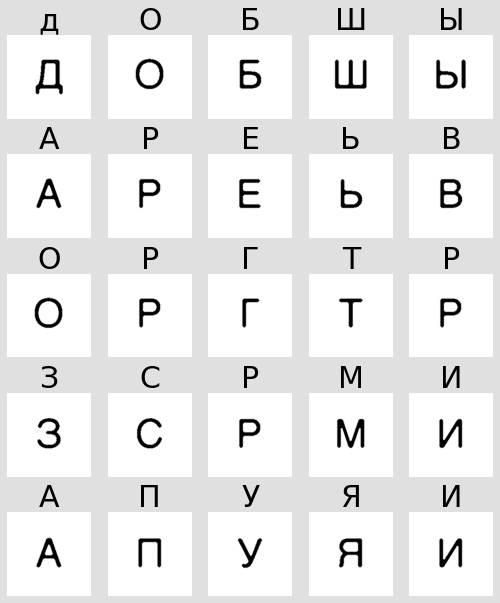

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
from pytesseract import image_to_string
import numpy as np
from PIL import Image
mpl.rcParams['axes.titlesize'] = 30
%matplotlib inline


def remove_elements(image):
    """
    Удаляет из изображения объекты небольшого размера

    Параметры
    ---------
    image : numpy.ndarray
        Черно-белое изображение, где фон - черный, а объекты - белые

    Возвращает
    ----------
    numpy.ndarray
        Черно-белое изображение без объектов небольшого размера
    """
    # получаем данные по найденным компонентам
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(
        image, connectivity=8)
    # получаем размеры каждой компоненты
    sizes = stats[1:, -1]
    # не рассматриваем фон как компоненту
    nb_components = nb_components - 1
    # определяем минимальный размер компоненты
    min_size = 300
    # формируем итоговое изображение
    image = np.zeros((output.shape))
    # перебираем все компоненты в изображении и сохраняем только тогда, когда она больше min_size
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            image[output == i + 1] = 255
    return image


def image_preprocessing(image):
    """
    Предобработка изображения (скриншота)

    Параметры
    ---------
    image : numpy.ndarray
        Скриншот игры, где находится игровое поле

    Возвращает
    ----------
    numpy.ndarray
        Черно-белое квадратное белое изображение с черными буквами
    """
    # преобразование изображения в черно-белое
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # значение по координате y, начиная с которого нужно рассматривать изображение
    y = 600
    # значение по координате x, начиная с которого нужно рассматривать изображение
    x = 30
    # высота рассматриваемого участка изображения
    h = 800
    # ширина рассматриваемого участка изображения
    w = 800
    # вырезаем необходимую часть изображения
    image = image[y:y+h, x:x+w]
    # применение пороговой функции
    image = cv2.threshold(
        image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    # медианная фильтрация
    image = cv2.medianBlur(image, 7)
    # инвертируем изображение
    image = 255 - image
    # удаляем лишние элементы на изображении
    image = remove_elements(image)
    # размытие изображения на основе фильтра Гаусса
    image = cv2.GaussianBlur(image, (3, 3), 2, 2)
    # размытие изображения фильтром Гаусса
    kernel = np.array([[-1, -1, -1],
                       [-1, 9, -1],
                       [-1, -1, -1]])
    image = cv2.filter2D(image, -1, kernel)
    # инвертируем результат
    return 255 - image


def letters_recognition(image):
    """
    Распознает все буквы на скриншоте

    Параметры
    ---------
    image : numpy.ndarray
        Скриншот игры, где находится игровое поле

    Возвращает
    ----------
    list[str]
        Список распознанных букв
    """
    # предобработка изображения
    image = image_preprocessing(image)
    # дополнительные опции конфигурации
    config = '--psm 10 --oem 0 ' \
        + 'tessedit_char_whitelist=абвгдежзийклмнопрстуфхцчшщъыьэюя'
    # высота и ширина обрезанного с буквой изображения
    height = width = 170
    # список распознанных букв
    letters = []
    # строим графики
    fig, axs = plt.subplots(5, 5, figsize=(10, 10))
    fig.patch.set_facecolor('#E0E0E0')
    # перебор координат по сетке
    for i, y in enumerate(range(0, 700, 155)):
        for j, x in enumerate(range(0, 700, 150)):
            # обрезанное изображение
            crop_image = image[y:y+height, x:x+width]
            # добавление белой границы вокруг каждого обрезанного фрагмента
            bordersize = 10
            crop_image = cv2.copyMakeBorder(
                np.float32(crop_image),
                top=bordersize,
                bottom=bordersize,
                left=bordersize,
                right=bordersize,
                borderType=cv2.BORDER_CONSTANT,
                value=[255, 255, 255]
            )
            # конвертация изображение в объект Image в оттенках серого
            crop_image = Image.fromarray(crop_image).convert('L')
            # распознавание буквы
            data = image_to_string(crop_image, lang='rus', config=config)
            axs[i, j].imshow(crop_image, cmap="gray", vmin=0, vmax=255)
            axs[i, j].set_title(str(data[0]))
            axs[i, j].axis('off')
            # добавляем букву в список распознанных букв
            letters += [data[0]]
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    plt.show()
    return letters


# загрузка изображения по указанному пути
image = cv2.imread('../images/screenshot_example_1.png')

letters = letters_recognition(image)

In [2]:
print(*[' '.join(letters[i*5:i*5+5]) for i in range(5)], sep='\n')

д О Б Ш Ы
А Р Е Ь В
О Р Г Т Р
З С Р М И
А П У Я И


In [3]:
''.join(letters).lower()

'добшыареьворгтрзсрмиапуяи'